In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib import colors as mcolors



from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display, Markdown, Latex
import csv
import random

import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from numpy import linalg as LA
from sklearn.metrics.pairwise import pairwise_distances

(150, 2)


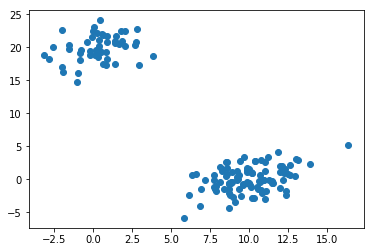

In [2]:
np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
print(X.shape)  # 150 samples with 2 dimensions
plt.scatter(X[:,0], X[:,1])
plt.show()

In [50]:
X = np.array([0.40,0.53,0.22,0.38,0.35,0.32,0.26,0.19,0.08,0.41,0.45,0.30]).reshape(6,2)
print(X)
D=2

[[ 0.4   0.53]
 [ 0.22  0.38]
 [ 0.35  0.32]
 [ 0.26  0.19]
 [ 0.08  0.41]
 [ 0.45  0.3 ]]


In [6]:
np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
print(X.shape)  # 150 samples with 2 dimensions
plt.scatter(X[:,0], X[:,1])
plt.show()
N = len(X)
D =2
def get_dist(instance1, instance2):
    
    return np.linalg.norm(instance1-instance2)

In [55]:
cs  = [Cluster(pos) for pos in X]


array([ 0.4 ,  0.53])

In [57]:

cs_pos = [X]
cs = []
l = N+1
x0 = X.copy()
while len(x0)>1:
    
    dist = pairwise_distances(x0)
    for i in range(len(dist)):
        dist[i, i] = np.inf
    i, j = np.unravel_index(
        np.argmin(dist, axis=None), 
        dist.shape
    )
    pos_cluster = (x0[i] + x0[j])/D
    x0 = np.delete(x0, (i, j), axis=0)
    x0 = np.vstack([x0, pos_cluster])
    cs_pos.append(x0)
    cs.append((i, j))
    l +=1

In [40]:
cs

[(2, 5), (1, 3), (1, 2), (1, 2), (0, 1)]

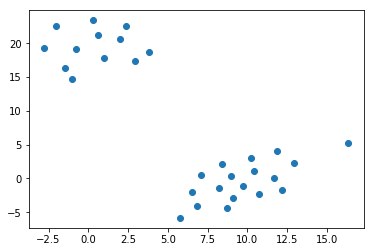

In [64]:
i_c = 120
plt.scatter(cs_pos[i_c][:,0], cs_pos[i_c][:,1])

(130, 2)


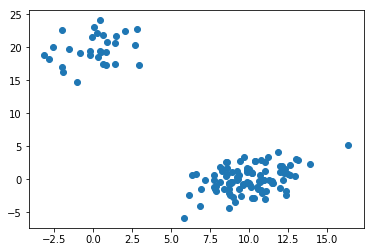

In [116]:
import sys
np.inf 

np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[30,])
X = np.concatenate((a, b),)
print(X.shape)  # 150 samples with 2 dimensions
plt.scatter(X[:,0], X[:,1])
plt.show()
N = len(X)
D =2
def get_dist(c1, c2):
    
    return np.linalg.norm(c1.pos-c2.pos)

In [117]:
class Cluster():
    def __init__(self, id, pos, dist_previous=None, left=None, right=None):
        self.id = id
        self.pos = pos
        self.left=left
        self.right=right
        self.dist_previous=dist_previous

    
cs  = [Cluster(id, pos) for id, pos in enumerate(X)]
cs_evo = []
cs_evo.append(cs)


while len(cs)>1:
#for l in range(10):
    #dist = pairwise_distances(x0)
    dist=[]
    for i in range(len(cs)):
        for j in range(i+1,len(cs)):
            item = {
                "left":cs[i],
                "right":cs[j],
                 "dist":get_dist(cs[i], cs[j])
            }
            dist.append(item)
        
    i_min = np.argmin([item["dist"] for item in dist])
    ci = dist[i_min]["left"]
    cj = dist[i_min]["right"]
    ci_pos = ci.pos
    cj_pos = cj.pos
    pos_cluster = (ci_pos + cj_pos)/D
    cs = [c for c in cs if c.id!=ci.id and c.id!=cj.id]
    new_cluster = Cluster(ci.id, pos_cluster, dist_previous = dist[i_min]["dist"], left=ci, right=cj )
    cs.append(new_cluster)
    cs_evo.append(cs)

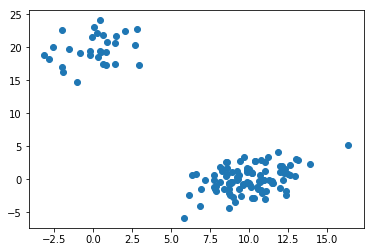

In [125]:

data = [c.pos for c in cs_evo[3]]
plt.scatter(X[:,0], X[:,1])
plt.show()

In [113]:
data

[array([ 9.21188389, -0.15188589]),
 array([ 10.76840064,   2.95244645]),
 array([ 8.24213268,  1.29094802]),
 array([ 5.7967009 , -5.83776714]),
 array([ 6.3499309 ,  0.63959515]),
 array([ 8.1057123 , -0.45887277]),
 array([ 8.72084884, -4.40444487]),
 array([ 10.4006121 ,   2.71240817]),
 array([  1.95503402,  21.98602715]),
 array([ -1.4985815 ,  20.50349583]),
 array([ -0.7664081 ,  21.30693205]),
 array([  2.27768001,  21.62763958]),
 array([  0.95901841,  19.87247968]),
 array([ -1.27562588,  19.26898089]),
 array([ -0.35050873,  23.4198941 ]),
 array([  1.49912084,  19.44886828]),
 array([  1.48256428,  19.71376506]),
 array([ -1.41259576,  21.66814229]),
 array([  1.95570427,  18.72649307]),
 array([ -2.23957747,  20.63746835]),
 array([  0.99794159,  17.06253152]),
 array([ -3.09149799,  18.55132059]),
 array([ -2.14212935,  19.00851881]),
 array([ -3.87491537,  17.55693523]),
 array([  0.61143795,  19.76377231]),
 array([  1.09217492,  18.30015949]),
 array([ 8.86218972, -0.

In [73]:
len([Cluster(id, pos) for id, pos in enumerate(X)])

30

In [74]:
np.argmin([item["dist"] for item in dist])

0

In [79]:
dist[0]["left"].id

9